In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 11.1

In [5]:
df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


- `pulled_left:` Outcome ${0, 1}$ - indicator if the animal pulled the left-hand lever.


- `prosoc_left:` Predict ${0, 1}$ - Indicator if left-hand lever was(1) or not(0) the prosocial options.


- `condition:` Predict ${0, 1}$ - Indicator if there is a partner (1) or not (0) in the end table. 

### R Code 11.2

In [6]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


- treatment= $0$: prosoc_left = $0$ and contition= $0$: Two food items on **right** and **no partner**.


- treatment= $1$: prosoc_left = $1$ and contition= $0$: Two food items on **left** and **no partner**.


- treatment= $0$: prosoc_left = $0$ and contition= $1$: Two food items on **right** and **has partner**.


- treatment= $1$: prosoc_left = $1$ and contition= $1$: Two food items on **left** and **has partner**.

### R Code 11.3

In [7]:
df.pivot_table(['prosoc_left', 'condition'], 'treatment', aggfunc='count', margins=True)

,condition,prosoc_left
treatment,,
1,126,126
2,126,126
3,126,126
4,126,126
All,504,504


In [8]:
def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_k \sim \mbox{to be determined} $$

### R Code 11.4

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha $$

$$ \alpha \sim Normal(0, \omega) $$


$\omega = 10$ to start

In [9]:
# Creating data list to model
data_list_partial = df[['pulled_left', 'actor']].to_dict('list')
data_list_partial['N'] = len(df)
data_list_partial['qty_chimpanzees'] = len(df.actor.unique())

data_list_partial.keys()

dict_keys(['pulled_left', 'actor', 'N', 'qty_chimpanzees'])

In [10]:
model_partial = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 10);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial = stan.build(model_partial, data=data_list_partial)
samples_partial = posteriori_partial.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_13_9shfe/model_otww5cyi.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_13_9shfe/model_otww5cyi.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   5% (400/8000)
Sampling:  14% (1100/8000)
Sampling:  22% (1800/8000)
Sampling:  48% (3800/8000)
Sampling:  68% (5400/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.2e

In [11]:
az.summary(samples_partial, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.342,0.237,-0.718,0.027,0.004,0.003,3522.0,2501.0,1.0
alpha[1],11.315,5.425,3.880,18.908,0.136,0.100,2014.0,1885.0,1.0
alpha[2],-0.641,0.259,-1.052,-0.224,0.005,0.003,3033.0,2408.0,1.0
alpha[3],-0.648,0.248,-1.050,-0.262,0.004,0.003,3517.0,2625.0,1.0
alpha[4],-0.336,0.245,-0.722,0.058,0.005,0.003,2921.0,2624.0,1.0
alpha[5],0.576,0.254,0.169,0.973,0.004,0.003,3315.0,2519.0,1.0
alpha[6],2.126,0.383,1.489,2.678,0.007,0.005,3445.0,2227.0,1.0


In [12]:
samples_partial = az.from_pystan(
    posterior_model=posteriori_partial,
    posterior=samples_partial,
    observed_data=['pulled_left', 'actor']
)

### R Code 11.5

In [13]:
# extract prior from quap
omega = 10
N = 1000

norm_prior = np.random.normal(0, omega, N)

### R Code 11.6

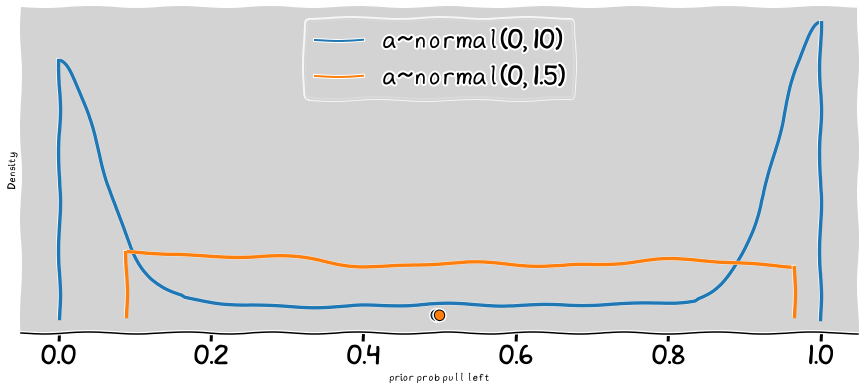

In [14]:
p = inv_logit(norm_prior)

omega = 1.5

better_p = inv_logit( np.random.normal(0, omega, N) ) 

az.plot_density([p, better_p],
                data_labels=['a~normal(0, 10)', 'a~normal(0, 1.5)'], 
                figsize=(15, 6))

plt.title('')
plt.xlabel('prior prob pull left')
plt.ylabel('Density')

plt.show()

In [15]:
model_partial_better = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial_better = stan.build(model_partial_better, data=data_list_partial)
samples_partial_better = posteriori_partial_better.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_b4q0sg8x/model_rj4e4nsu.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_b4q0sg8x/model_rj4e4nsu.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  11% (900/8000)
Sampling:  36% (2900/8000)
Sampling:  61% (4900/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.9e-05 seconds
  1000 transitions using 10 leapfrog steps

In [16]:
az.summary(samples_partial_better, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.326,0.230,-0.696,0.020,0.003,0.003,5764.0,3007.0,1.0
alpha[1],3.927,0.709,2.825,5.001,0.010,0.008,5584.0,2715.0,1.0
alpha[2],-0.624,0.246,-1.047,-0.266,0.003,0.002,7085.0,2893.0,1.0
alpha[3],-0.621,0.240,-0.999,-0.234,0.003,0.002,6277.0,2938.0,1.0
alpha[4],-0.330,0.240,-0.689,0.069,0.003,0.003,5205.0,3057.0,1.0
alpha[5],0.563,0.251,0.170,0.952,0.003,0.002,6558.0,3124.0,1.0
alpha[6],2.003,0.356,1.461,2.570,0.005,0.004,5307.0,2759.0,1.0


In [17]:
samples_parcial_better = az.from_pystan(
    posterior=samples_partial_better,
)

### R Code 11.7

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 10) $$

In [18]:
# quap code to get priori

### R Code 11.8

In [19]:
p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 10, (4, N))

p = [inv_logit(alpha + beta) for beta in betas]

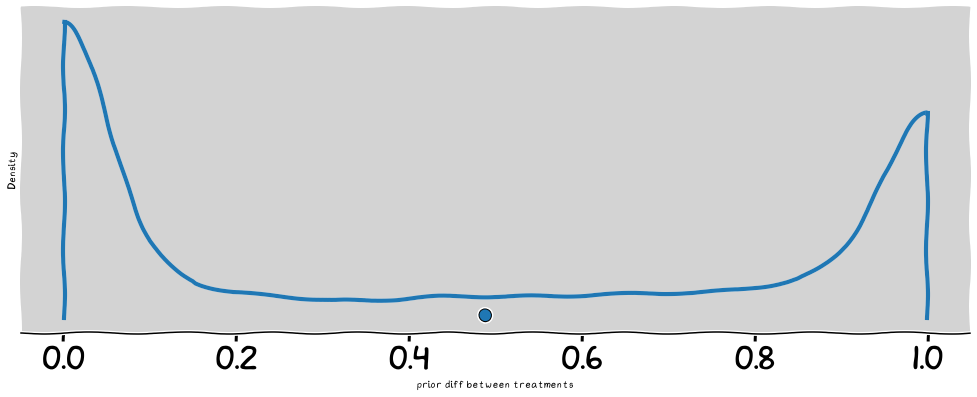

In [20]:
az.plot_density(np.absolute(p[0] - p[1]), figsize=(17, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.9

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 0.5) $$

In [21]:
better_p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 0.5, (4, N))

better_p = [inv_logit(alpha + beta) for beta in betas]

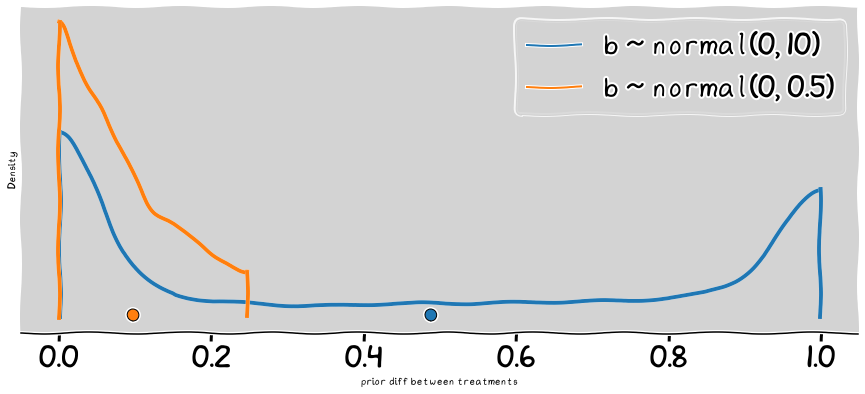

In [22]:
az.plot_density([
        np.absolute(p[0] - p[1]), 
        np.absolute(better_p[0] - better_p[1])
    ], 
    data_labels=['b ~ normal(0, 10)', 'b ~ normal(0, 0.5)'],
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

In [23]:
np.mean(np.absolute(better_p[0] - better_p[1]))

0.09692789449772228

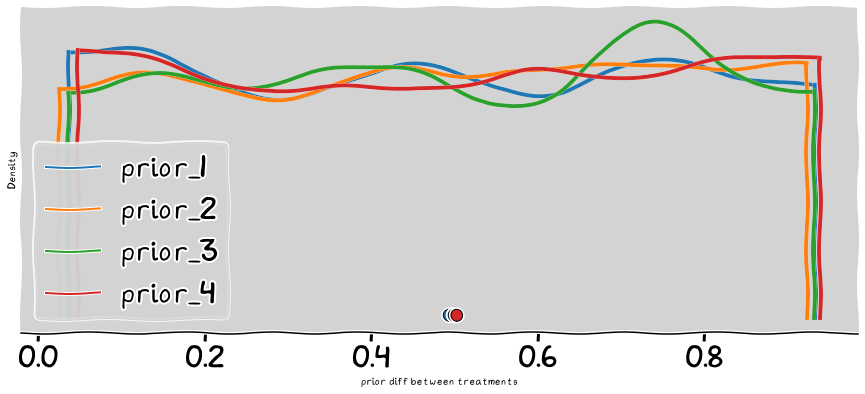

In [24]:
# Plot the 4 prior

az.plot_density([
        better_p[0], 
        better_p[1], 
        better_p[2], 
        better_p[3], 
    ],
    data_labels=['prior_1', 'prior_2', 'prior_3', 'prior_4'], 
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.10

In [25]:
data_list = df[['pulled_left', 'actor', 'treatment']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_chimpanzees'] = len(df.actor.unique())
data_list['qty_treatment'] = len(df.treatment.unique())

data_list.keys()

dict_keys(['pulled_left', 'actor', 'treatment', 'N', 'qty_chimpanzees', 'qty_treatment'])

### R Code 11.11

In [26]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_treatment;
        int pulled_left[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
        vector[qty_treatment] beta;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [27]:
samples_chimpanzees = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['pulled_left', 'actor', 'treatment']
)

In [28]:
az.summary(samples_chimpanzees, var_names=['alpha', 'beta'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.457,0.331,-0.988,0.063,0.009,0.006,1470.0,2287.0,1.0
alpha[1],3.901,0.775,2.608,5.027,0.013,0.009,4115.0,2232.0,1.0
alpha[2],-0.759,0.337,-1.273,-0.194,0.008,0.006,1596.0,2333.0,1.0
alpha[3],-0.762,0.336,-1.281,-0.207,0.008,0.006,1610.0,2378.0,1.0
alpha[4],-0.460,0.331,-0.990,0.062,0.009,0.006,1339.0,2027.0,1.0
alpha[5],0.466,0.334,-0.064,0.997,0.008,0.006,1602.0,2627.0,1.0
alpha[6],1.952,0.428,1.267,2.619,0.009,0.007,2155.0,2282.0,1.0
beta[0],-0.028,0.287,-0.466,0.439,0.008,0.006,1348.0,1976.0,1.0
beta[1],0.490,0.284,0.041,0.936,0.008,0.005,1415.0,2416.0,1.0
beta[2],-0.373,0.290,-0.832,0.082,0.008,0.005,1453.0,2016.0,1.0


### R Code 11.12

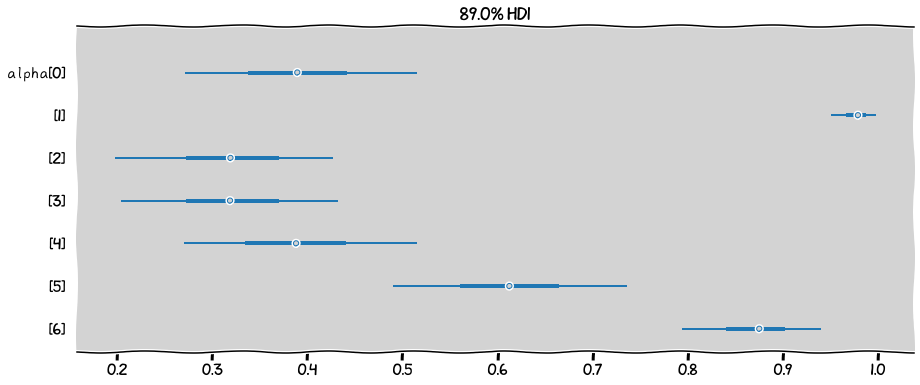

In [29]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

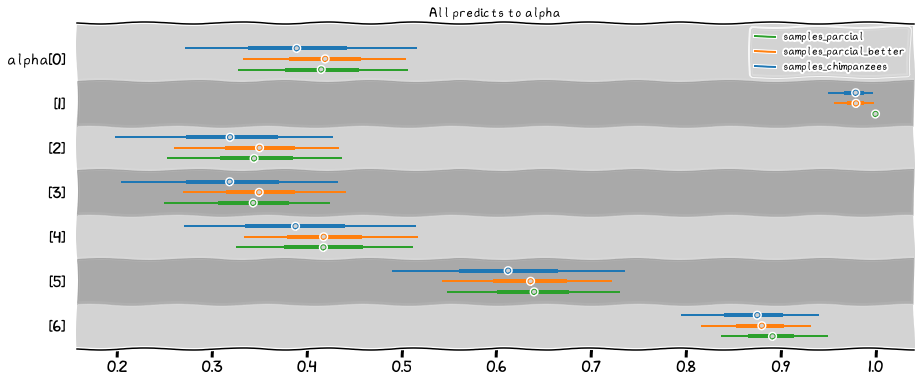

In [30]:
ax = az.plot_forest([samples_chimpanzees, samples_parcial_better, samples_partial], 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities,
                    model_names=['samples_chimpanzees', 'samples_parcial_better', 'samples_parcial'],
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

plt.title('All predicts to alpha')

plt.show()

### R Code 11.13

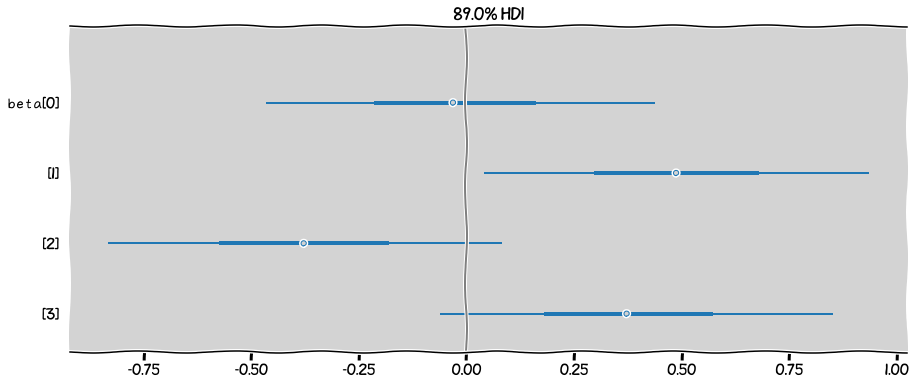

In [31]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))
plt.axvline(x=0, c='gray')
plt.show()

### R Code 8.14

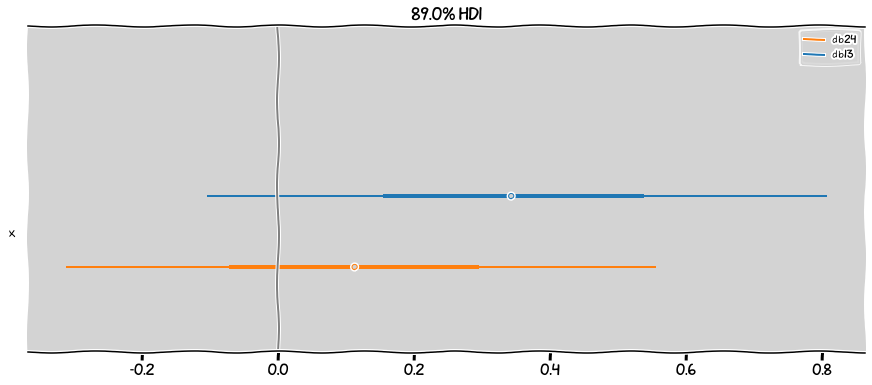

In [32]:
beta_0 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)
beta_1 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)
beta_2 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)
beta_3 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)

diff_beta_0_2 = az.extract(beta_0 - beta_2)
diff_beta_1_3 = az.extract(beta_1 - beta_3)

az.plot_forest(
    [diff_beta_0_2.beta.values, diff_beta_1_3.beta.values],
    combined=True,  # Joint all chains 
    kind="forestplot", # or ridgeplot to plot densities
    # transform=inv_logit,
    model_names=['db13', 'db24'],
    hdi_prob=0.89,
    figsize=(15, 6)
)

plt.axvline(x=0, c='gray')

plt.show()

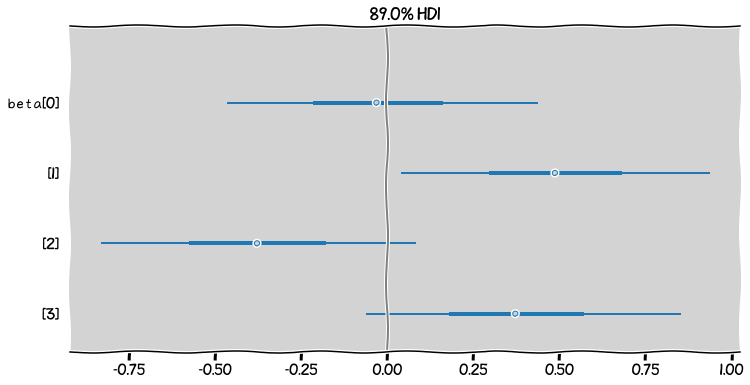

In [33]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(12, 6))

plt.axvline(x=0, c='gray')
plt.show()

### R Code 11.15

In [151]:
pl = df.groupby(['actor', 'treatment'])[['actor', 'treatment', 'pulled_left']].mean(['pulled_left'])

pl.loc[pl.actor == 1]

actor  treatment  pulled_left
actor treatment                               
1     1            1.0        1.0     0.333333
      2            1.0        2.0     0.500000
      3            1.0        3.0     0.277778
      4            1.0        4.0     0.555556

### R Code 11.16 and R Code 11.17

In [200]:
RN_hdi_min, RN_hdi_max = az.hdi(RN, hdi_prob=0.89)
RN_hdi_min

0.7980719421169256

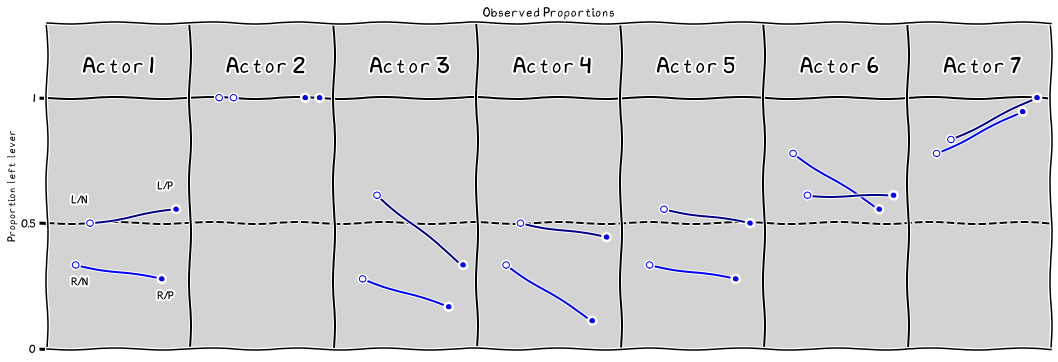

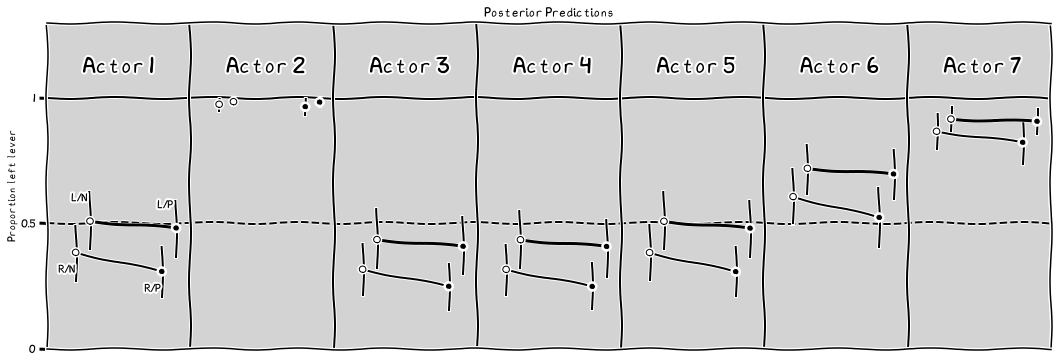

In [218]:
# R Code 11.16

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    RN, LN, RP, LP = pl.loc[pl.actor == i + 1, 'pulled_left'].values

    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN, RP], color='blue')
    plt.plot(0.2 + i, RN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.8 + i, RP, 'o', markerfacecolor='blue', color='white')
    
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN, LP], color='darkblue')
    plt.plot(0.3 + i, LN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.9 + i, LP, 'o', markerfacecolor='blue', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.17, y=RN - 0.08, s='R/N')
        plt.text(x=0.77, y=RP - 0.08, s='R/P')
        plt.text(x=0.17, y=LN + 0.08, s='L/N')
        plt.text(x=0.77, y=LP + 0.08, s='L/P')
    
plt.title('Observed Proportions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()


# R Code 11.17
# ============

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    alpha_chimp = az.extract(samples_chimpanzees.posterior.alpha.sel(alpha_dim_0=i)).alpha.values
    
    RN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)).beta.values)
    LN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values)
    RP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)).beta.values)
    LP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values)
    
    # To R/N and R/P
    # ===============
    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN.mean(), RP.mean()], color='black')
    
    # Plot hdi compatibility interval
    RN_hdi_min, RN_hdi_max = az.hdi(RN, hdi_prob=0.89)
    RP_hdi_min, RP_hdi_max = az.hdi(RP, hdi_prob=0.89)
    plt.plot([0.2 + i, 0.2 + i], [RN_hdi_min, RN_hdi_max], c='black')
    plt.plot([0.8 + i, 0.8 + i], [RP_hdi_min, RP_hdi_max], c='black')
    
    # Plot points
    plt.plot(0.2 + i, RN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.8 + i, RP.mean(), 'o', markerfacecolor='black', color='white')
    
    # To L/N and L/P
    # ===============
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN.mean(), LP.mean()], color='black', linewidth=3)

    # Plot hdi compatibility interval
    LN_hdi_min, LN_hdi_max = az.hdi(LN, hdi_prob=0.89)
    LP_hdi_min, LP_hdi_max = az.hdi(LP, hdi_prob=0.89)
    plt.plot([0.3 + i, 0.3 + i], [LN_hdi_min, LN_hdi_max], c='black')
    plt.plot([0.9 + i, 0.9 + i], [LP_hdi_min, LP_hdi_max], c='black')

    plt.plot(0.3 + i, LN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.9 + i, LP.mean(), 'o', markerfacecolor='black', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.08, y=RN.mean() - 0.08, s='R/N')
        plt.text(x=0.68, y=RP.mean() - 0.08, s='R/P')
        plt.text(x=0.17, y=LN.mean() + 0.08, s='L/N')
        plt.text(x=0.77, y=LP.mean() + 0.08, s='L/P')
    
plt.title('Posterior Predictions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()

### R Code 11.18

In [219]:
df['side'] = df.prosoc_left + 1  # Right 1, Left 2  - Because R start index in 1
df['cond'] = df.condition + 1  # no partner 1, partner 2 - Because R start index in 1

### R Code 11.19

In [221]:
# Creating data list 2 to model
data_list2 = df[['pulled_left', 'actor', 'side', 'cond']].to_dict('list')
data_list2['N'] = len(df)
data_list2['qty_actors'] = len(df.actor.unique())
data_list2['qty_side'] = len(df.side.unique())
data_list2['qty_cond'] = len(df.cond.unique())

data_list2.keys()

dict_keys(['pulled_left', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_side', 'qty_cond'])

In [223]:
model2 = """
    data {
        int N;
        int qty_actors;
        int qty_side;
        int qty_cond;
        
        int pulled_left[N];
        int actor[N];
        int side[N];
        int cond[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_side] bs;
        vector[qty_cond] bc;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        bs ~ normal(0, 0.5);
        bc ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + bs[ side[i] ] + bc[ cond[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori2 = stan.build(model2, data=data_list2)
samples2 = posteriori2.sample(num_chains=4, num_samples=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp: In constructor ‘model_2dwfndv7_namespace::model_2dwfndv7::model_2dwfndv7(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp:80:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   80 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 14.4s
Building: 14.5s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s


/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp: In instantiation of ‘void model_2dwfndv7_namespace::model_2dwfndv7::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp:526:69:   required from here
/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp:317:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  317 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 15.4s
Building: 15.5s
Building: 15.6s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s


/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp: In instantiation of ‘void model_2dwfndv7_namespace::model_2dwfndv7::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.9.1/models/2dwfndv7/model_2dwfndv7.cpp:456:7:   required from ‘void model_2dwfndv7_namespace::model_2dwfndv7::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Matr

Building: 20.2s
Building: 20.3s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.5s
Building: 25.6s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.3s
Building: 26.4s
Building: 26.5s
Building

Building: 38.0s, done.
Messages from stanc:
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to

In [224]:
samples_chimpanzees_2 = az.from_pystan(
    posterior_model=posteriori2,
    posterior=samples2,
    observed_data=['pulled_left', 'actor', 'side', 'cond']
)

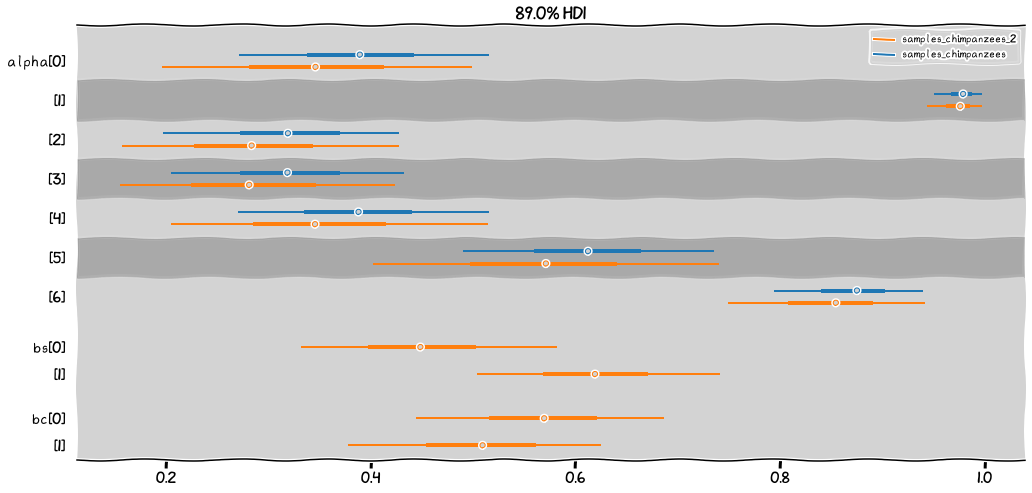

In [233]:
ax = az.plot_forest([samples_chimpanzees, samples_chimpanzees_2],
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha', 'bs', 'bc'], 
                    model_names=['samples_chimpanzees', 'samples_chimpanzees_2'],
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(17, 8))
plt.show()

### R Code 11.21

To viewing data from rethinking packages

### R Code 11.22

Comparing two models